In [29]:
import torch
from models.networks import get_model
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from data_utils.data_stats import *

import numpy as np
import matplotlib.pyplot as plt



In [30]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
data_path = './beton/'
eval_batch_size = 1024
checkpoint = 'in21k_cifar10'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the model and specify the pre-trained weights
model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=CLASS_DICT[dataset],
                  checkpoint='in21k_cifar10')

model = nn.Sequential(
    nn.Flatten(1, -1),model
)

Weights already downloaded
Load_state output <All keys matched successfully>


In [22]:
# Set seed values for PyTorch and NumPy for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)

# creating an input
mean = 0.5
std = 0.5/3
input = mean + std*torch.randn((3,64,64)) # should be of size 3,64,64
input.unsqueeze_(0) # create a mini-batch as expected by the model
input.requires_grad_()

# Function that takes an array an normalizes its content to be within the range 0-1
def norm_01(array):
    return(array-np.min(array))/(np.max(array)-np.min(array))

# Function that takes in an input batch (with only 1 element) and displays it as an image
def show_im(batch):
    img = batch.reshape(3,64,64).permute(1,2,0)
    img_np = img.detach().numpy()
    plt.imshow(norm_01(img_np))


In [61]:
# Set seed values for PyTorch and NumPy for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)


# ---------- Load the CIFAR-10 test dataset -------------

normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))
unnormalize = transforms.Normalize((-0.4914/0.2471, -0.4822/0.2435, -0.4465/0.2616), (1/0.2471, 1/0.2435, 1/0.2616))
transforms_cifar = transforms.Compose([transforms.ToTensor(), transforms.Resize(64),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))])

# Function that takes an array an normalizes its content to be within the range 0-1
def norm_01(array):
    return(array-np.min(array))/(np.max(array)-np.min(array))

# Function that takes in an input batch (with only 1 element) and displays it as an image
def show_im_unnorm(batch):
    img = unnormalize(batch.reshape(3,64,64)).permute(1,2,0)
    img_np = img.detach().numpy()
    plt.imshow(norm_01(img_np))
    plt.show()

def show_im(batch):
    img = unnormalize(batch.reshape(3,64,64)).permute(1,2,0)
    img_np = img.detach().numpy()
    plt.imshow(norm_01(img_np))
    plt.show()

cifar10 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)

# dog 12, 16, horse 13, 17

input = cifar10[17][0]
input.unsqueeze_(0) # create a mini-batch as expected by the model
input.requires_grad_()


Files already downloaded and verified


tensor([[[[-1.0364, -1.0007, -0.9293,  ..., -0.5841, -0.4096, -0.3223],
          [-1.0285, -0.9938, -0.9244,  ..., -0.5157, -0.2915, -0.1794],
          [-1.0126, -0.9799, -0.9144,  ..., -0.3788, -0.0555,  0.1062],
          ...,
          [ 0.8521,  0.9880,  1.2598,  ...,  1.2836,  1.3054,  1.3163],
          [ 1.1378,  1.1963,  1.3134,  ...,  1.3292,  1.3471,  1.3560],
          [ 1.2806,  1.3005,  1.3401,  ...,  1.3520,  1.3679,  1.3759]],

         [[ 0.0812,  0.1053,  0.1536,  ..., -0.2248, -0.0638,  0.0167],
          [ 0.0973,  0.1204,  0.1667,  ..., -0.1634,  0.0479,  0.1536],
          [ 0.1295,  0.1506,  0.1929,  ..., -0.0406,  0.2714,  0.4274],
          ...,
          [ 0.8421,  0.9861,  1.2739,  ...,  1.3082,  1.3303,  1.3414],
          [ 1.1401,  1.2015,  1.3243,  ...,  1.3545,  1.3726,  1.3816],
          [ 1.2890,  1.3092,  1.3494,  ...,  1.3776,  1.3937,  1.4018]],

         [[ 0.4968,  0.5343,  0.6093,  ...,  0.0059,  0.1933,  0.2870],
          [ 0.4968,  0.5334,  

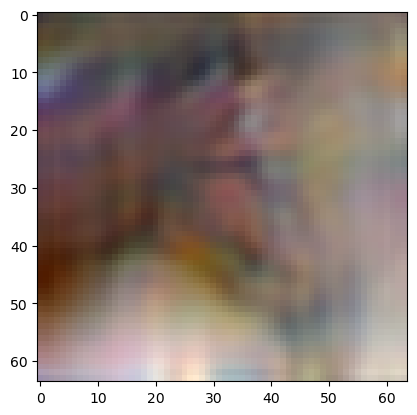

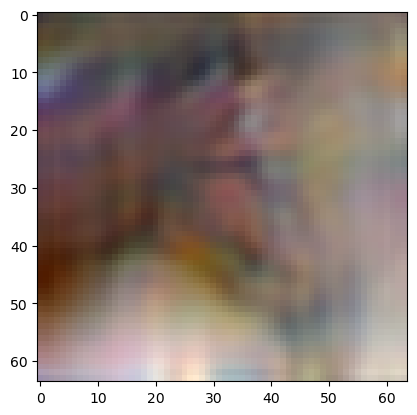

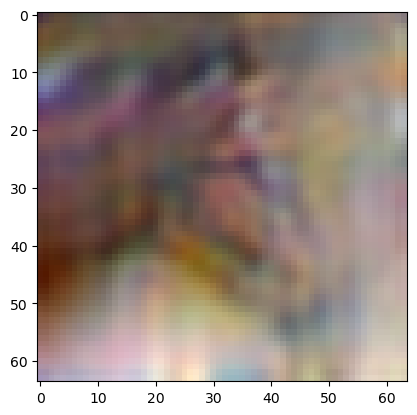

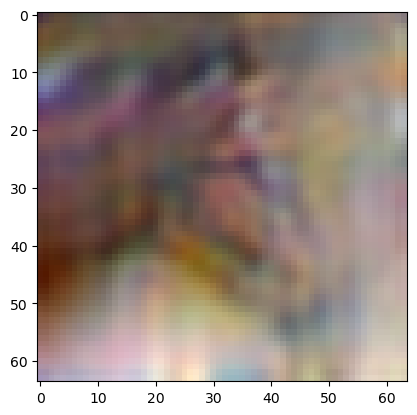

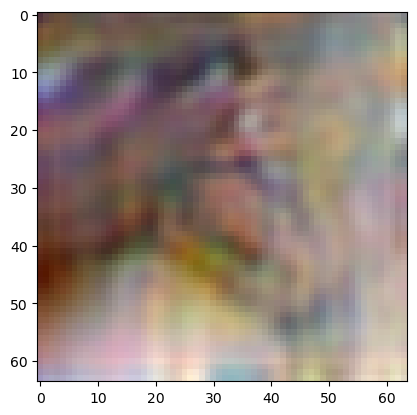

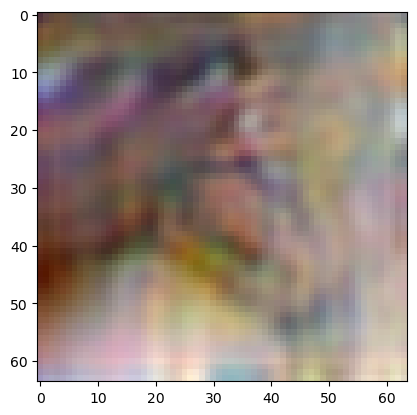

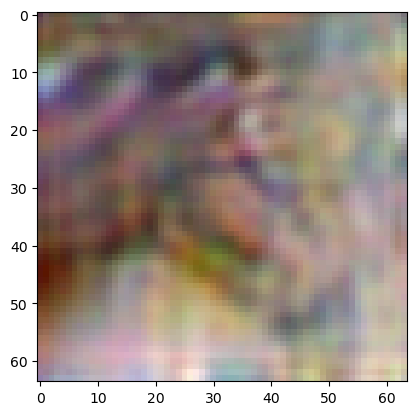

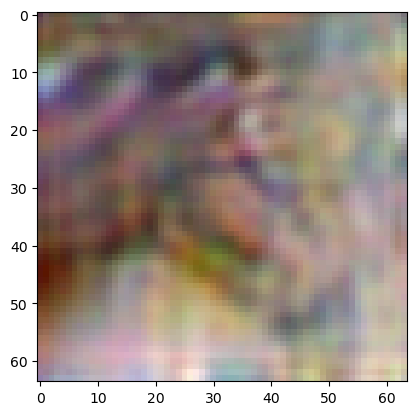

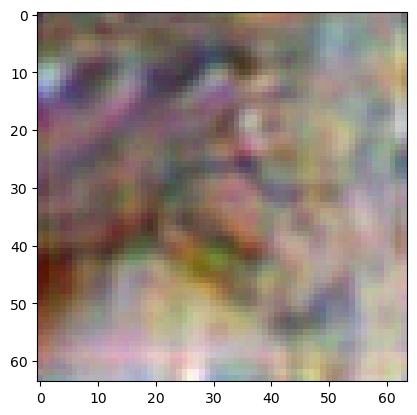

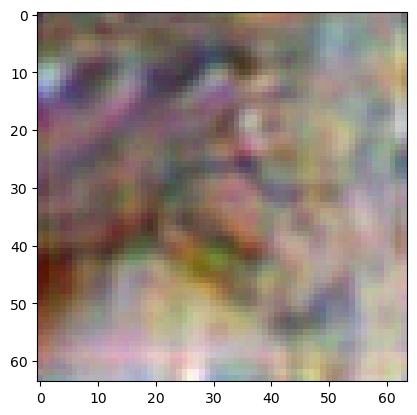

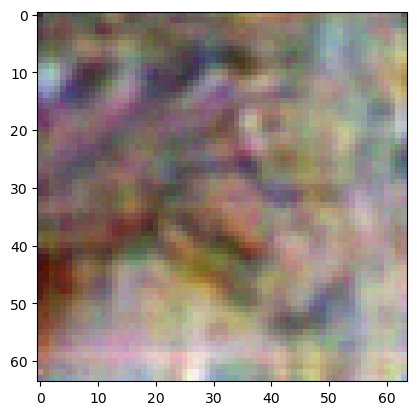

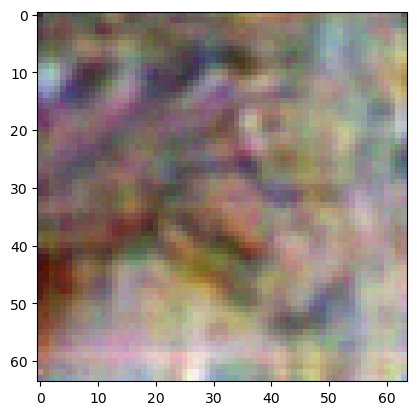

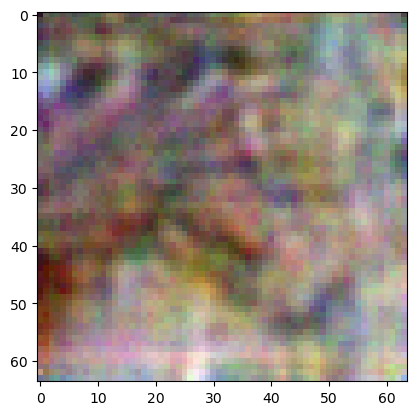

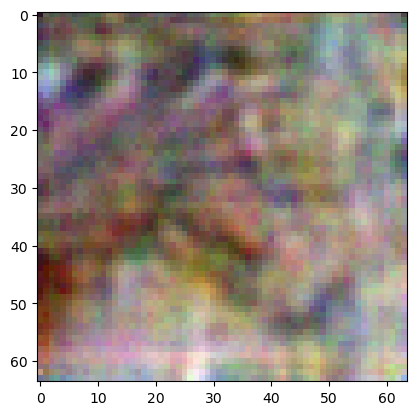

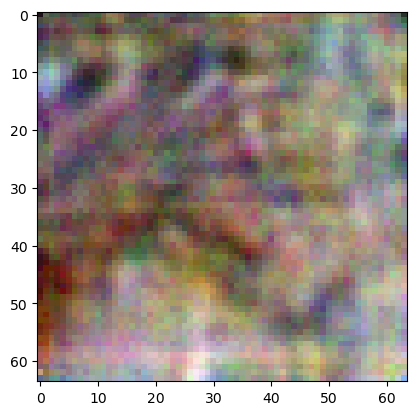

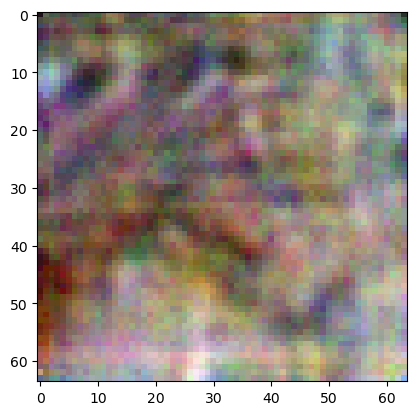

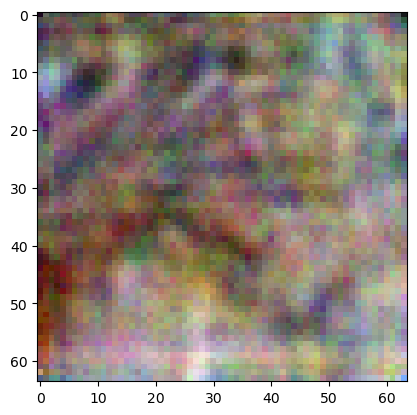

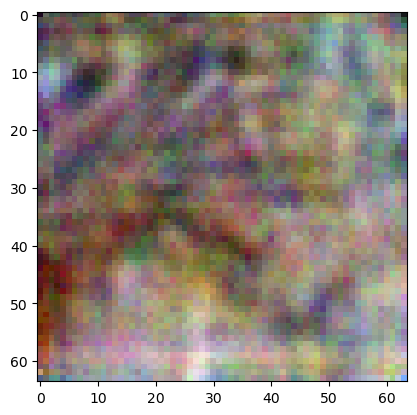

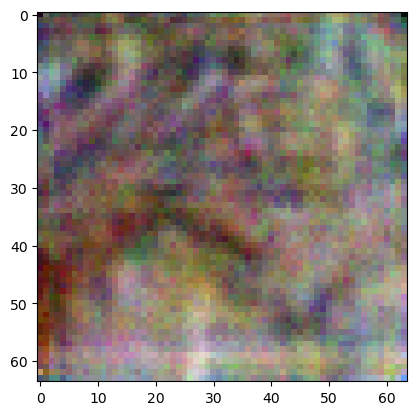

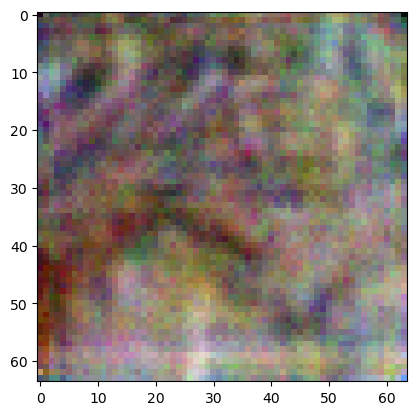

In [63]:
# Class I want to optimize
idx = 7 # 0: airplanes, 1: cars, 2: birds, 3: cats, 4: deer, 5: dogs, 6: frogs, 7: horses, 8: ships, 9: trucks


epochs = 1000
start_step_size = 0.01
end_step_size = 0.01


start_sig = 0.5 #was 1 Having a decaying sigma seems to yield better results
end_sig = 0.1 
jitter = 7 # Jitter doesn't seem to help too much
theta_decay = 0.0001 # Theta decay seems to help (0.02 seems good)

num_im_save = 10

checkpoints = []

for epoch in range(epochs):
  
  model.zero_grad()
  if input.grad != None:
    input.grad.zero_()
  y_pred = model.forward(input)
  #print(y_pred[0,idx])
  y_pred[0,idx].backward()

  g = input.grad
  # ox, oy = np.random.randint(-jitter, jitter+1, 2)
  
  with torch.no_grad():

    step_size = start_step_size + ((end_step_size - start_step_size) * epoch) / epochs
    input += step_size/np.abs(g).mean() * g

    # input = input.roll( ox, -1) # apply jitter shift
    # input = input.roll( oy, -2)

    #input = input.mul((1.0 - theta_decay)) # weight decay

    sig = start_sig + ((end_sig - start_sig) * epoch) / epochs
    blurrer = transforms.GaussianBlur(kernel_size=5, sigma=sig)
    input = blurrer(input)    

  input.requires_grad_()

  if (epoch+1) % (epochs/num_im_save) == 0:
    checkpoints.append(input)
    show_im(input)
    show_im_unnorm(input)
    plt.show()



In [6]:
with torch.no_grad():
    output = model(input)

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output)
print(output)
print(torch.argmax(probabilities))
print(torch.max(probabilities))

tensor([[ 0.3825, -0.3020,  0.5321, -1.0795, -0.0704,  6.6308,  0.7137,  0.0877,
          0.6696,  0.2128]])
tensor(5)
tensor(0.9851)


/var/folders/0f/d0nxyk0d5cq8n2nlbpm3wp3h0000gn/T/ipykernel_9918/1259139260.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(output)
